In [5]:
### import necessary packages
import uproot
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import time
from tqdm import tqdm
from itertools import permutations, product, combinations, chain

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,9)

In [58]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)  # allows duplicate elements
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


def energy_resolution(energy,a=30.98,b=0.37):
    res_rel = np.divide(a,np.sqrt(energy))+b
    res_abs = energy * res_rel/100
    return res_abs



In [7]:
### transforms a root file in a single index file
### had issues reading out the multiindex file although I think this is the way to go for an optimized script
### the function also sorts in zp for the further analysis
def transform_root_file_and_sort_by_z(filename):
    events=uproot.open(filename)["events"]
    events2=events["events"]# why do I have to do that
    df =  events2.pandas.df(["ed", "zp","xp","yp","trackid","parentid","etot"]) # make a pandas data frame with the parameters of interest
    df2 = df.sort_values('zp', ascending=False).sort_index(level='entry', sort_remaining=False) # sort by z
    df3 = df2.reset_index(level="entry") # remove multiindex1
    final_df = df3.reset_index(level="subentry") # remove multiindex2
    return final_df

In [8]:
### function to obtain summed energy using z resolution only
### the code scans trough the data frame and adds up energy values until it is resolvable in z
### code is added to a list and put back in a df 

### toDO: there is a lot of ways to improve the efficience (benchmark at the moment on my machine 5min for 100k, 45min for 1M events)
### toDO: the first entry is dead on arrival, just use N-1 for analysis later


def get_data_frame_with_summed_energy(data_frame,z_res): #pick a resolution in z and a data frame
    energy_in_one = 0 # initialize the variable to add energy if below z_res
    energy_list = [] # lists for later
    event_list = []
    energy_tot_list = []
    for j in data_frame.index:
    #tqdm(df4.index):#len(df2.groupby(level=0))):
      if(j>0 and j<(len(data_frame))): #ignore last and first event since it is annoying when doing +-1
            if((np.abs(data_frame.at[j-1,"zp"]-data_frame.at[j,"zp"]))<z_res and (data_frame.at[j,"entry"]==data_frame.at[j-1,"entry"])): #if same event and below z_res add up   
                    energy_in_one+=data_frame.at[j,"ed"] 
            elif(data_frame.at[j,"entry"]!=data_frame.at[j+1,"entry"]) : # if the event ends, add into the list the energy which is stored at the moment
                    energy_list.append(energy_in_one)
                    event_list.append(data_frame.at[j,"entry"]) # 
                    energy_tot_list.append(data_frame.at[j,"etot"])
                    energy_in_one = data_frame.at[j,"ed"]    
            else:   # if resolveable, write out the energy summed so far                    
                    energy_list.append(energy_in_one)
                    event_list.append(data_frame.at[j-1,"entry"]) # j-1, since we are at a point where J is already from the next event
                    energy_tot_list.append(data_frame.at[j-1,"etot"])
                    energy_in_one = data_frame.at[j,"ed"]      

    df_new_with_z = pd.DataFrame()
    df_new_with_z["event_id"] = event_list
    df_new_with_z["energy"] = energy_list
    df_new_with_z["etot"] = energy_tot_list
    return df_new_with_z
    


In [9]:
### in progress
### toDO: x,y is not sorted. So there may be events which bounce crazy and cause problems if they are at the same z, this has to be checked
### toDO: the first event is dead on arrival, just use N-1 for later analysis

def get_data_frame_with_summed_energy_xy(data_frame,z_res,xy_res):
    energy_in_one = 0
    energy_list = []
    event_list = []
    energy_tot_list = []
    for j in data_frame.index:
        if(j>0 and j<(len(data_frame))):
            if  (data_frame.at[j,"entry"]==data_frame.at[j-1,"entry"] 
            and ((np.abs(data_frame.at[j-1,"zp"]-data_frame.at[j,"zp"])<z_res))
            and ((np.abs(data_frame.at[j-1,"xp"]-data_frame.at[j,"xp"])<xy_res)) 
            and ((np.abs(data_frame.at[j-1,"yp"]-data_frame.at[j,"yp"])<xy_res))):
                            energy_in_one+=data_frame.at[j,"ed"]
            elif(data_frame.at[j,"entry"]!=data_frame.at[j+1,"entry"]) :
                    energy_list.append(energy_in_one)
                    event_list.append(data_frame.at[j,"entry"])
                    energy_tot_list.append(data_frame.at[j,"etot"])
                    energy_in_one = data_frame.at[j,"ed"]    
            else:   # if resolveable, write out the energy summed so far                    
                    energy_list.append(energy_in_one)
                    event_list.append(data_frame.at[j-1,"entry"])
                    energy_tot_list.append(data_frame.at[j-1,"etot"])
                    energy_in_one = data_frame.at[j,"ed"] # j is the stored energy. The results look alright, but does this make problems in border cases?
                
        #else  print(j)
            
    df_new_with_xy  = pd.DataFrame() # make a new dataframe to fill with results (ladies and gentlemen, mr.inefficient)
    df_new_with_xy ["event_id"] = event_list # the event_id
    df_new_with_xy ["energy"] = energy_list # the energy
    df_new_with_xy ["etot"] = energy_tot_list # the total energy deposition, important for cuts later but also cross check 
    return df_new_with_xy    

In [10]:
def get_number_of_scatter(data_frame,number_of_events=10000,multiplicity=2): # number of events can be set by the length of your file (toDO: it may need a correction by 2), multiplicity is simply how many scatter you want
    scatter_list = [] # I love lists apparently
    fraction_above_multi = 0 # will be the final value for the fraction above a certain multiplicity
    for i in np.arange(0,data_frame.at[data_frame.index[-1], 'event_id']):
        scatter_list.append(len(data_frame[data_frame['event_id'] == i]))
    ## list comprehension below, isn't faster
    #different_num = [len(df_new[df_new['event_id'] == i]) for i in np.arange(0,df_new.at[df_new.index[-1], 'event_id'])]
    fraction_above_multi = np.divide(np.count_nonzero(np.asarray(scatter_list)>(multiplicity-1)),number_of_events) # just count all events above a certain multiplicity and calculate a ratio to the total events
    return fraction_above_multi

In [71]:
### adding energy requirements ###
### toDO: make energy resolution dependent on the energy 

def energy_criteria_selection(df,decay,e_res1=30.98,e_res2=0.37,permu=True):
    ### lets go through this complicated script using the positron example
    ### toDo: make it more modular

    if(decay=="positron_1MeV_test"): # pick the decay of choice
        ## first we want only events which left the entire energy in the detetor
        df = df[df["etot"].between(2022-energy_resolution(2022,e_res1,e_res2),2022+energy_resolution(2022,e_res1,e_res2))] # this works since we have the tot column all the same within one evt_id
        ## second we want only events where the positron left its energy in one deposition
        criteria2 = df["energy"].between(1000-energy_resolution(1000,e_res1,e_res2),1000+energy_resolution(1000,e_res1,e_res2)) # careful: if resolution is able to separate the positron, a new algorithm would be needed
        criteria_sum = criteria2
        list_index2 = df[criteria_sum]["event_id"]
        df = df[df['event_id'].isin(list_index2)] 
        ## third lets go to 511 keV detection 
        
        if(permu==False):
        ## this mode requires an exact deposition of 511 keV (within energy resolution)
            df_mult = df[df["energy"].between(511-energy_resolution(511,e_res1,e_res2),511+energy_resolution(511,e_res1,e_res2))] # apply your criteria, here 511 keV depositions 
            list_index3 = df_mult["event_id"] # get all event_ids left so far
            list_index4=  df_mult.groupby('event_id')["energy"].count() # group the event_ids full_filling and count how often
            list_index5 = [] # create an empty list because you are AlexF the list fetish guy
            for i in list_index3.unique(): # check for all event_ids (but only once, hence the unique) if they fulfill the criteria
                if(list_index4[i]==2): # if the number of event_ids in the df_mult frame exceeds a certain number (here 1), save the event_id
                    list_index5.append(i)
            df = df[df['event_id'].isin(list_index5)] # now go back to your original dataframe and select only those events which have the respective multiple scatters

            
        if(permu==True): ## permutations are not the same as combinations but screw the name...
            ## okay tricky part starts here.
            ## Lets assume we start with the following energy combination: [1000,511,180,329,2]
            df_perm = df
            loop_group = df_perm.groupby("event_id") # group them by event id
            list_index6 = [] # make some more lists
            list_index7= [] # oh yeah 
            list_index8 = [] # list it to me baby
            list_index9 = [] # can"t have enough lists
            debug_list = [] # this one is not used any more
            removal_list = [] # last one, I promise

            for i in np.unique(df_perm.event_id): # now check all event ids in the dataframe
                counter = 0 # set a counter which keeps track of 511 keV depositions
                if(i>0):# get rid of event 0, it fails anyway
                    loop_group.get_group(i) # get event by event
                    if(len(loop_group.get_group(i))>2): # only do this if there is more than 2 entries
                        list_index7 = list(combinations(loop_group.get_group(i).energy,1)) # build a list of all possible combinations of energy given the event_id
                        #print(list_index7)
                        # do some pre-filtering to save computer time
                        for element,energy_entry in enumerate(list_index7): # loop through all entries
                            if(np.sum(energy_entry)>(511+energy_resolution(511,e_res1,e_res2))): # if an entry is above 511keV, no need to keep it as it won't help on the sum anyway
                                #print('remove because to high')
                                removal_list.append(energy_entry) # add the energy to the removal list
                                #this what we are left with: [511,180,329,2]
                            if(np.sum(energy_entry)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(energy_entry)<(511+energy_resolution(511,e_res1,e_res2))): # remove single 511 keV entries and count them
                               # print('remove since energy is already working but raise counter')
                                counter += 1 # raise the counter for each 511 keV deposition
                                removal_list.append(energy_entry) # but remove afterwards
                                #this what we are left with: [180,329,2]
                        list_index7=[x for x in list_index7 if x not in removal_list] # here the actual removing happens
                        #print(list_index7, 'filtered')
                        #print(counter)
                        list_index6=list(combinations(list_index7,len(list_index7))) # Here we get the combination of all remaining entries. This is done a bit stupid but I loved lists in this script 
                        #print(np.sum(list_index6))
                        if(counter>0 and np.sum(list_index6)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index6)<(511+energy_resolution(511,e_res1,e_res2))): # if their is already a 511 keV entry and the remaining are 511 keV you are done (remember you have removed the positron)
                            counter += 1
                            # for our example this would be true and we were done. Let's pretend its not
                        if(counter>=2):
                            #print('counter high enough')
                            list_index8.append(i)    
                        combo_list = [] # haha you thought lists are over? Never. This one will contain possible cominbations
                        entry_list = [] # in retrospective I think I do not need that one, but a list is a list
                        sum_list=[] #the sum of all combos will be stored here - mhmm a list
                        for j, combo in enumerate(powerset(list_index7), 1): # powerset now goes from single entries to combinations of all entries
                            if(len(combo)>1 and np.sum(combo)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(combo)<(511+energy_resolution(511,e_res1,e_res2))): 
                                ## for non single entries and with the sum within the energy resolution check now how close they are to 511keV
                                #print('combo', combo, np.sum(combo))
                                sum_list.append(np.abs(np.sum(combo)-511))
                                entry_list.append(j)
                                combo_list.append(combo)
                                #print(np.abs(np.sum(combo)-511),j)
                        if(len(entry_list)>0):
                            counter +=1 # since we have something at 511, raise the counter
                            #print("value",entry_list[np.argmin(sum_list)],"somth",combo_list[np.argmin(sum_list)])
                        if(len(sum_list)>0): # but now we have to take care those energy entries are not re-used
                            for select_values in combo_list[np.argmin(sum_list)]:
                                list_index7.remove(select_values) # in our case this will be [180,329,2]
                                #print(list_index7,"now without")
                            if(counter>0 and np.sum(list_index7)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index7)<(511+energy_resolution(511,e_res1,e_res2))): # so if the rest is 511 keV we are where we want to be
                                counter += 1 
                        if(counter>=2): # should be ==2, but redundancy prevents from failing this
                        #print('yes, here I am')
                            list_index8.append(i)
                    #print(len(list_index8))
                    #print(len(np.unique(list_index8)))
            df_perm = df_perm[df_perm['event_id'].isin(list_index8)]  # filter the frame            
            df=df_perm
             
    elif(decay=="2vECB+"): 
            ## first we want only events which left the entire energy in the detetor
        df = df[df["etot"].between(31-energy_resolution(31,e_res1,e_res2)+1022-energy_resolution(1022,e_res1,e_res2),2856+energy_resolution(2856,e_res1,e_res2))] # this works since we have the tot column all the same within one evt_id
        ## second we want only events where the positron left its energy in one deposition
        criteria2 = df["energy"].between(0,1834+energy_resolution(1834,e_res1,e_res2)) # careful: if resolution is able to separate the positron, a new algorithm would be needed
        criteria_sum = criteria2
        list_index2 = df[criteria_sum]["event_id"]
        df = df[df['event_id'].isin(list_index2)]
        df_perm = df
        ## third we want to pick only those events where an algorithm would reconstruct 511 keV photons out of various energy depositions
        if(permu==False):
        ## can be used to filter for at least for full deposition
        ## may be faster to use this first, to get the obvious cases?
            df_mult = df[df["energy"].between(511-energy_resolution(511,e_res1,e_res2),511+energy_resolution(511,e_res1,e_res2))] # apply your criteria, here 511 keV depositions 
            list_index3 = df_mult["event_id"] # get all event_ids left so far
            list_index4=  df_mult.groupby('event_id')["energy"].count() # group the event_ids full_filling and count how often
            list_index5 = [] # create an empty list because you are AlexF the list fetish guy
            for i in list_index3.unique(): # check for all event_ids (but only once, hence the unique) if they fulfill the criteria
                if(list_index4[i]==2): # if the number of event_ids in the df_mult frame exceeds a certain number (here 1), save the event_id
                    list_index5.append(i)
            df = df[df['event_id'].isin(list_index5)] # now go back to your original dataframe and select only those events which have the respective multiple scatters

        if(permu==True): # permutations are not the same as combinations but screw the name...
            df_perm = df
            loop_group = df_perm.groupby("event_id") # group them by event id
            list_index6 = [] # make some more lists
            list_index7= [] # oh yeah 
            list_index8 = [] # list it to me baby
            list_index9 = []
            debug_list = []
            removal_list = [] # last one, I promise

            for i in np.unique(df_perm.event_id): # now check all event ids in the dataframe
                counter = 0
                if(i>0):                    
                    if(len(loop_group.get_group(i))>12):
                        print(i,len(loop_group.get_group(i)),"TOOOO LONG") ## has to be done otherwise the permutation script part crashes. neglible
                    if(len(loop_group.get_group(i))>2 and len(loop_group.get_group(i))<12):
                        loop_group.get_group(i) # and look into the values
                        list_index7 = list(combinations(loop_group.get_group(i).energy,1)) # build a list of all possible combinations of energy given the event_id
                        #print(list_index7,i)
                        for element,energy_entry in enumerate(list_index7):
                            if(np.sum(energy_entry)>(511+energy_resolution(511,e_res1,e_res2))):
                                #print('remove because to high')
                                removal_list.append(energy_entry)
                            if(np.sum(energy_entry)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(energy_entry)<(511+energy_resolution(511,e_res1,e_res2))):
                               # print('remove since energy is already working but raise counter')
                                counter += 1
                                removal_list.append(energy_entry)
                        list_index7=[x for x in list_index7 if x not in removal_list]
                        #print(list_index7, 'filtered')
                        #print(counter)
                        list_index6=list(combinations(list_index7,len(list_index7)))
                        #print(np.sum(list_index6))
                        if(counter>0 and np.sum(list_index6)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index6)<(511+energy_resolution(511,e_res1,e_res2))):
                            counter += 1
                        if(counter>=2):
                            #print('counter high enough')
                            list_index8.append(i)    
                        combo_list = []
                        entry_list = []
                        sum_list=[]
                        for j, combo in enumerate(powerset(list_index7), 1): # powerset now goes from single entries to combinations of all entries
                            if(len(combo)>1 and np.sum(combo)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(combo)<(511+energy_resolution(511,e_res1,e_res2))):
                                #print('combo', combo, np.sum(combo))
                                sum_list.append(np.abs(np.sum(combo)-511))
                                entry_list.append(j)
                                combo_list.append(combo)
                                #print(np.abs(np.sum(combo)-511),j)
                        if(len(entry_list)>0):
                            counter +=1
                            #print("value",entry_list[np.argmin(sum_list)],"somth",combo_list[np.argmin(sum_list)])
                        if(len(sum_list)>0):
                            for select_values in combo_list[np.argmin(sum_list)]:
                                list_index7.remove(select_values)
                                #print(list_index7,"now without")
                            if(counter>0 and np.sum(list_index7)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index7)<(511+energy_resolution(511,e_res1,e_res2))):
                                counter += 1
                        if(counter>=2):
                        #print('yes, here I am')
                            list_index8.append(i)
                    #print(len(list_index8))
                    #print(len(np.unique(list_index8)))
            df_perm = df_perm[df_perm['event_id'].isin(list_index8)]  # filter the frame            
            df=df_perm
    
    elif(decay=="0vECB+"):
        ## first we want only events which left the entire energy in the detetor
        df = df[df["etot"].between(2856-energy_resolution(2856,e_res1,e_res2),2856+energy_resolution(2856,e_res1,e_res2))] # this works since we have the tot column all the same within one evt_id
        ## second we want only events where the positron left its energy in one deposition
        criteria2 = df["energy"].between(1834-energy_resolution(1834,e_res1,e_res2),1834+energy_resolution(1834,e_res1,e_res2)) # careful: if resolution is able to separate the positron, a new algorithm would be needed
        criteria_sum = criteria2
        list_index2 = df[criteria_sum]["event_id"]
        df = df[df['event_id'].isin(list_index2)]
        df_perm = df
        ## third we want to pick only those events where an algorithm would reconstruct 511 keV photons out of various energy depositions
        if(permu==False):
        ## can be used to filter for at least for full deposition
        ## may be faster to use this first, to get the obvious cases?
            df_mult = df[df["energy"].between(511-energy_resolution(511,e_res1,e_res2),511+energy_resolution(511,e_res1,e_res2))] # apply your criteria, here 511 keV depositions 
            list_index3 = df_mult["event_id"] # get all event_ids left so far
            list_index4=  df_mult.groupby('event_id')["energy"].count() # group the event_ids full_filling and count how often
            list_index5 = [] # create an empty list because you are AlexF the list fetish guy
            for i in list_index3.unique(): # check for all event_ids (but only once, hence the unique) if they fulfill the criteria
                if(list_index4[i]==2): # if the number of event_ids in the df_mult frame exceeds a certain number (here 1), save the event_id
                    list_index5.append(i)
            df = df[df['event_id'].isin(list_index5)] # now go back to your original dataframe and select only those events which have the respective multiple scatters

        if(permu==True): # permutations are not the same as combinations but screw the name...
            df_perm = df
            loop_group = df_perm.groupby("event_id") # group them by event id
            list_index6 = [] # make some more lists
            list_index7= [] # oh yeah 
            list_index8 = [] # list it to me baby
            list_index9 = []
            debug_list = []
            removal_list = [] # last one, I promise

            for i in np.unique(df_perm.event_id): # now check all event ids in the dataframe
                counter = 0
                if(i>0):
                    if(len(loop_group.get_group(i))>2):
                        loop_group.get_group(i) # and look into the values
                        list_index7 = list(combinations(loop_group.get_group(i).energy,1)) # build a list of all possible combinations of energy given the event_id
                        #print(list_index7)
                        for element,energy_entry in enumerate(list_index7):
                            if(np.sum(energy_entry)>(511+energy_resolution(511,e_res1,e_res2))):
                                #print('remove because to high')
                                removal_list.append(energy_entry)
                            if(np.sum(energy_entry)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(energy_entry)<(511+energy_resolution(511,e_res1,e_res2))):
                               # print('remove since energy is already working but raise counter')
                                counter += 1
                                removal_list.append(energy_entry)
                        list_index7=[x for x in list_index7 if x not in removal_list]
                        #print(list_index7, 'filtered')
                        #print(counter)
                        list_index6=list(combinations(list_index7,len(list_index7)))
                        #print(np.sum(list_index6))
                        if(counter>0 and np.sum(list_index6)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index6)<(511+energy_resolution(511,e_res1,e_res2))):
                            counter += 1
                        if(counter>=2):
                            #print('counter high enough')
                            list_index8.append(i)    
                        combo_list = []
                        entry_list = []
                        sum_list=[]
                        for j, combo in enumerate(powerset(list_index7), 1): # powerset now goes from single entries to combinations of all entries
                            if(len(combo)>1 and np.sum(combo)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(combo)<(511+energy_resolution(511,e_res1,e_res2))):
                                #print('combo', combo, np.sum(combo))
                                sum_list.append(np.abs(np.sum(combo)-511))
                                entry_list.append(j)
                                combo_list.append(combo)
                                #print(np.abs(np.sum(combo)-511),j)
                        if(len(entry_list)>0):
                            counter +=1
                            #print("value",entry_list[np.argmin(sum_list)],"somth",combo_list[np.argmin(sum_list)])
                        if(len(sum_list)>0):
                            for select_values in combo_list[np.argmin(sum_list)]:
                                list_index7.remove(select_values)
                                #print(list_index7,"now without")
                            if(counter>0 and np.sum(list_index7)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index7)<(511+energy_resolution(511,e_res1,e_res2))):
                                counter += 1
                        if(counter>=2):
                        #print('yes, here I am')
                            list_index8.append(i)
                    #print(len(list_index8))
                    #print(len(np.unique(list_index8)))
            df_perm = df_perm[df_perm['event_id'].isin(list_index8)]  # filter the frame            
            df=df_perm 
        
    elif(decay=="0vECB+_strict"):
## first we want only events which left the entire energy in the detetor
        df = df[df["etot"].between(2856-energy_resolution(2856,e_res1,e_res2),2856+energy_resolution(2856,e_res1,e_res2))] # this works since we have the tot column all the same within one evt_id
        ## second we want only events where the positron left its energy in one deposition
        criteria2 = df["energy"].between(1801-energy_resolution(1801,e_res1,e_res2),1801+energy_resolution(1801,e_res1,e_res2)) # careful: if resolution is able to separate the positron, a new algorithm would be needed
        criteria_sum = criteria2
        list_index2 = df[criteria_sum]["event_id"]
        df = df[df['event_id'].isin(list_index2)]
        criteria3 = df["energy"].between(31.8-energy_resolution(31.8,e_res1,e_res2),31.8+energy_resolution(31.8,e_res1,e_res2)) # careful: if resolution is able to separate the positron, a new algorithm would be needed
        criteria_sum = criteria3
        list_index2 = df[criteria_sum]["event_id"]
        df = df[df['event_id'].isin(list_index2)]
        df_perm = df
        ## third we want to pick only those events where an algorithm would reconstruct 511 keV photons out of various energy depositions
        if(permu==False):
        ## can be used to filter for at least for full deposition
        ## may be faster to use this first, to get the obvious cases?
            df_mult = df[df["energy"].between(511-energy_resolution(511,e_res1,e_res2),511+energy_resolution(511,e_res1,e_res2))] # apply your criteria, here 511 keV depositions 
            list_index3 = df_mult["event_id"] # get all event_ids left so far
            list_index4=  df_mult.groupby('event_id')["energy"].count() # group the event_ids full_filling and count how often
            list_index5 = [] # create an empty list because you are AlexF the list fetish guy
            for i in list_index3.unique(): # check for all event_ids (but only once, hence the unique) if they fulfill the criteria
                if(list_index4[i]==2): # if the number of event_ids in the df_mult frame exceeds a certain number (here 1), save the event_id
                    list_index5.append(i)
            df = df[df['event_id'].isin(list_index5)] # now go back to your original dataframe and select only those events which have the respective multiple scatters

        if(permu==True): # permutations are not the same as combinations but screw the name...
            df_perm = df
            loop_group = df_perm.groupby("event_id") # group them by event id
            list_index6 = [] # make some more lists
            list_index7= [] # oh yeah 
            list_index8 = [] # list it to me baby
            list_index9 = []
            debug_list = []
            removal_list = [] # last one, I promise

            for i in np.unique(df_perm.event_id): # now check all event ids in the dataframe
                counter = 0
                if(i>0):
                    if(len(loop_group.get_group(i))>2):
                        loop_group.get_group(i) # and look into the values
                        list_index7 = list(combinations(loop_group.get_group(i).energy,1)) # build a list of all possible combinations of energy given the event_id
                        #print(list_index7)
                        for element,energy_entry in enumerate(list_index7):
                            if(np.sum(energy_entry)>(511+energy_resolution(511,e_res1,e_res2))):
                                #print('remove because to high')
                                removal_list.append(energy_entry)
                            if(np.sum(energy_entry)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(energy_entry)<(511+energy_resolution(511,e_res1,e_res2))):
                               # print('remove since energy is already working but raise counter')
                                counter += 1
                                removal_list.append(energy_entry)
                        list_index7=[x for x in list_index7 if x not in removal_list]
                        #print(list_index7, 'filtered')
                        #print(counter)
                        list_index6=list(combinations(list_index7,len(list_index7)))
                        #print(np.sum(list_index6))
                        if(counter>0 and np.sum(list_index6)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index6)<(511+energy_resolution(511,e_res1,e_res2))):
                            counter += 1
                        if(counter>=2):
                            #print('counter high enough')
                            list_index8.append(i)    
                        combo_list = []
                        entry_list = []
                        sum_list=[]
                        for j, combo in enumerate(powerset(list_index7), 1): # powerset now goes from single entries to combinations of all entries
                            if(len(combo)>1 and np.sum(combo)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(combo)<(511+energy_resolution(511,e_res1,e_res2))):
                                #print('combo', combo, np.sum(combo))
                                sum_list.append(np.abs(np.sum(combo)-511))
                                entry_list.append(j)
                                combo_list.append(combo)
                                #print(np.abs(np.sum(combo)-511),j)
                        if(len(entry_list)>0):
                            counter +=1
                            #print("value",entry_list[np.argmin(sum_list)],"somth",combo_list[np.argmin(sum_list)])
                        if(len(sum_list)>0):
                            for select_values in combo_list[np.argmin(sum_list)]:
                                list_index7.remove(select_values)
                                #print(list_index7,"now without")
                            if(counter>0 and np.sum(list_index7)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index7)<(511+energy_resolution(511,e_res1,e_res2))):
                                counter += 1
                        if(counter>=2):
                        #print('yes, here I am')
                            list_index8.append(i)
                    #print(len(list_index8))
                    #print(len(np.unique(list_index8)))
            df_perm = df_perm[df_perm['event_id'].isin(list_index8)]  # filter the frame            
            df=df_perm 
        
    elif(decay=="2vB+B+"):
    ## first we want only events which left the entire energy in the detetor
        df = df[df["etot"].between(31-energy_resolution(31,e_res1,e_res2)+2044-energy_resolution(2044,e_res1,e_res2),2856+energy_resolution(2856,e_res1,e_res2))] # this works since we have the tot column all the same within one evt_id
        ## second we want only events where the positron left its energy in one deposition
        criteria2 = df["energy"].between(0,812+energy_resolution(812,e_res1,e_res2)) # careful: if resolution is able to separate the positron, a new algorithm would be needed
        criteria_sum = criteria2
        list_index2 = df[criteria_sum]["event_id"]
        df = df[df['event_id'].isin(list_index2)]
        
        
        df_prefilter = df[df["energy"].between(511+energy_resolution(511,e_res1,e_res2),812+energy_resolution(812,e_res1,e_res2))] # apply your criteria, here 511 keV depositions 
        list_p3 = df_prefilter["event_id"] # get all event_ids left so far
        list_p4=  df_prefilter.groupby('event_id')["energy"].count() # group the event_ids full_filling and count how often
        list_p5 = [] # create an empty list because you are AlexF the list fetish guy
        for i in list_p3.unique(): # check for all event_ids (but only once, hence the unique) if they fulfill the criteria
            if(list_p4[i]>1): # if the number of event_ids in the df_mult frame exceeds a certain number (here 1), save the event_id
                list_p5.append(i)
        #print(len(list_p5))        
        df = df[~df['event_id'].isin(list_p5)] # now go back to your original dataframe and select only those events which have the respective multiple scatters
        
        
        ## third we want to pick only those events where an algorithm would reconstruct 511 keV photons out of various energy depositions
        if(permu==False):
        ## can be used to filter for at least for full deposition
        ## may be faster to use this first, to get the obvious cases?
            df_mult = df[df["energy"].between(511-energy_resolution(511,e_res1,e_res2),511+energy_resolution(511,e_res1,e_res2))] # apply your criteria, here 511 keV depositions 
            list_index3 = df_mult["event_id"] # get all event_ids left so far
            list_index4=  df_mult.groupby('event_id')["energy"].count() # group the event_ids full_filling and count how often
            list_index5 = [] # create an empty list because you are AlexF the list fetish guy
            for i in list_index3.unique(): # check for all event_ids (but only once, hence the unique) if they fulfill the criteria
                if(list_index4[i]==4): # if the number of event_ids in the df_mult frame exceeds a certain number (here 1), save the event_id
                    list_index5.append(i)
            df = df[df['event_id'].isin(list_index5)] # now go back to your original dataframe and select only those events which have the respective multiple scatters
        
        if(permu==True): # permutations are not the same as combinations but screw the name...
            df_perm = df
            loop_group = df_perm.groupby("event_id") # group them by event id
            list_index6 = [] # make some more lists
            list_index7= [] # oh yeah 
            list_index8 = [] # list it to me baby
            list_index9 = []
            debug_list = []
            removal_list = [] # last one, I promise

            for i in np.unique(df_perm.event_id): # now check all event ids in the dataframe
                counter = 0
                if(i>0):
                    if(len(loop_group.get_group(i))>2 and len(loop_group.get_group(i))<12):
                        loop_group.get_group(i) # and look into the values
                        list_index7 = list(combinations(loop_group.get_group(i).energy,1)) # build a list of all possible combinations of energy given the event_id
                        #print(list_index7)
                        for element,energy_entry in enumerate(list_index7):
                            if(np.sum(energy_entry)>(511+energy_resolution(511,e_res1,e_res2))):
                                #print('remove because to high')
                                removal_list.append(energy_entry)
                            if(np.sum(energy_entry)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(energy_entry)<(511+energy_resolution(511,e_res1,e_res2))):
                               # print('remove since energy is already working but raise counter')
                                counter += 1
                                removal_list.append(energy_entry)
                        list_index7=[x for x in list_index7 if x not in removal_list]
                        #print(list_index7, 'filtered')
                        #print(counter)
                        list_index6=list(combinations(list_index7,len(list_index7)))
                        #print(np.sum(list_index6))
                        if(counter>0 and np.sum(list_index6)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index6)<(511+energy_resolution(511,e_res1,e_res2))):
                            counter += 1
                        if(counter==4):
                            #print('counter high enough')
                            list_index8.append(i)    
                        for k in np.arange(0,4,1):
                            combo_list = []
                            entry_list = []
                            sum_list=[]
                            for j, combo in enumerate(powerset(list_index7), 1): # powerset now goes from single entries to combinations of all entries
                                if(len(combo)>1 and np.sum(combo)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(combo)<(511+energy_resolution(511,e_res1,e_res2))):
                                        #print('combo', combo, np.sum(combo))
                                    sum_list.append(np.abs(np.sum(combo)-511))
                                    entry_list.append(j)
                                    combo_list.append(combo)
                                    #print(np.abs(np.sum(combo)-511),j)
                            if(len(entry_list)>0):
                                counter +=1
                                #print("value",entry_list[np.argmin(sum_list)],"somth",combo_list[np.argmin(sum_list)])
                            if(len(sum_list)>0):
                                for select_values in combo_list[np.argmin(sum_list)]:
                                    list_index7.remove(select_values)
                            if(counter==3 and np.sum(list_index7)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index7)<(511+energy_resolution(511,e_res1,e_res2))):
                                counter += 1
                        if(counter==4):
                        #print('yes, here I am')
                            list_index8.append(i)
                    #print(len(list_index8))
                    #print(len(np.unique(list_index8)))
            df_perm = df_perm[df_perm['event_id'].isin(list_index8)]  # filter the frame            
            df=df_perm 
         
    elif(decay=="0vB+B+"):
    ## first we want only events which left the entire energy in the detetor
        df = df[df["etot"].between(2856-energy_resolution(2856,e_res1,e_res2),2856+energy_resolution(2856,e_res1,e_res2))] # this works since we have the tot column all the same within one evt_id
        ## second we want only events where the positron left its energy in one deposition
        criteria2 = df["energy"].between(812-energy_resolution(812,e_res1,e_res2),812+energy_resolution(812,e_res1,e_res2)) # careful: if resolution is able to separate the positron, a new algorithm would be needed
        criteria_sum = criteria2
        list_index2 = df[criteria_sum]["event_id"]
        df = df[df['event_id'].isin(list_index2)]
        
        
        df_prefilter = df[df["energy"].between(511+energy_resolution(511,e_res1,e_res2),812+energy_resolution(812,e_res1,e_res2))] # apply your criteria, here 511 keV depositions 
        list_p3 = df_prefilter["event_id"] # get all event_ids left so far
        list_p4=  df_prefilter.groupby('event_id')["energy"].count() # group the event_ids full_filling and count how often
        list_p5 = [] # create an empty list because you are AlexF the list fetish guy
        for i in list_p3.unique(): # check for all event_ids (but only once, hence the unique) if they fulfill the criteria
            if(list_p4[i]>1): # if the number of event_ids in the df_mult frame exceeds a certain number (here 1), save the event_id
                list_p5.append(i)
        #print(len(list_p5))        
        df = df[~df['event_id'].isin(list_p5)] # now go back to your original dataframe and select only those events which have the respective multiple scatters
        
        ########## ONLY TO HERE IT IS CHECKED!!! #######
        ## third we want to pick only those events where an algorithm would reconstruct 511 keV photons out of various energy depositions
        if(permu==False):
        ## can be used to filter for at least for full deposition
        ## may be faster to use this first, to get the obvious cases?
            df_mult = df[df["energy"].between(511-energy_resolution(511,e_res1,e_res2),511+energy_resolution(511,e_res1,e_res2))] # apply your criteria, here 511 keV depositions 
            list_index3 = df_mult["event_id"] # get all event_ids left so far
            list_index4=  df_mult.groupby('event_id')["energy"].count() # group the event_ids full_filling and count how often
            list_index5 = [] # create an empty list because you are AlexF the list fetish guy
            for i in list_index3.unique(): # check for all event_ids (but only once, hence the unique) if they fulfill the criteria
                if(list_index4[i]==4): # if the number of event_ids in the df_mult frame exceeds a certain number (here 1), save the event_id
                    list_index5.append(i)
            df = df[df['event_id'].isin(list_index5)] # now go back to your original dataframe and select only those events which have the respective multiple scatters
        
        if(permu==True): # permutations are not the same as combinations but screw the name...
            df_perm = df
            loop_group = df_perm.groupby("event_id") # group them by event id
            list_index6 = [] # make some more lists
            list_index7= [] # oh yeah 
            list_index8 = [] # list it to me baby
            list_index9 = []
            debug_list = []
            removal_list = [] # last one, I promise

            for i in np.unique(df_perm.event_id): # now check all event ids in the dataframe
                counter = 0
                if(i>0):
                    if(len(loop_group.get_group(i))>2 and len(loop_group.get_group(i))<12):
                        loop_group.get_group(i) # and look into the values
                        list_index7 = list(combinations(loop_group.get_group(i).energy,1)) # build a list of all possible combinations of energy given the event_id
                        #print(list_index7)
                        for element,energy_entry in enumerate(list_index7):
                            if(np.sum(energy_entry)>(511+energy_resolution(511,e_res1,e_res2))):
                                #print('remove because to high')
                                removal_list.append(energy_entry)
                            if(np.sum(energy_entry)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(energy_entry)<(511+energy_resolution(511,e_res1,e_res2))):
                               # print('remove since energy is already working but raise counter')
                                counter += 1
                                removal_list.append(energy_entry)
                        list_index7=[x for x in list_index7 if x not in removal_list]
                        #print(list_index7, 'filtered')
                        #print(counter)
                        list_index6=list(combinations(list_index7,len(list_index7)))
                        #print(np.sum(list_index6))
                        if(counter>0 and np.sum(list_index6)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index6)<(511+energy_resolution(511,e_res1,e_res2))):
                            counter += 1
                        if(counter==4):
                            #print('counter high enough')
                            list_index8.append(i)    
                        for k in np.arange(0,4,1):
                            combo_list = []
                            entry_list = []
                            sum_list=[]
                            for j, combo in enumerate(powerset(list_index7), 1): # powerset now goes from single entries to combinations of all entries
                                if(len(combo)>1 and np.sum(combo)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(combo)<(511+energy_resolution(511,e_res1,e_res2))):
                                        #print('combo', combo, np.sum(combo))
                                    sum_list.append(np.abs(np.sum(combo)-511))
                                    entry_list.append(j)
                                    combo_list.append(combo)
                                    #print(np.abs(np.sum(combo)-511),j)
                            if(len(entry_list)>0):
                                counter +=1
                                #print("value",entry_list[np.argmin(sum_list)],"somth",combo_list[np.argmin(sum_list)])
                            if(len(sum_list)>0):
                                for select_values in combo_list[np.argmin(sum_list)]:
                                    list_index7.remove(select_values)
                            if(counter==3 and np.sum(list_index7)>(511-energy_resolution(511,e_res1,e_res2)) and np.sum(list_index7)<(511+energy_resolution(511,e_res1,e_res2))):
                                counter += 1
                        if(counter==4):
                        #print('yes, here I am')
                            list_index8.append(i)
                    #print(len(list_index8))
                    #print(len(np.unique(list_index8)))
            df_perm = df_perm[df_perm['event_id'].isin(list_index8)]  # filter the frame            
            df=df_perm 
         

    '''
    elif(decay=="0vRECEC"):
    elif(decay=="0vECEC"):

   
    '''
    return df
    

In [74]:
def get_surival_fraction_after_energy(inital_events,data_frame,z_res,xy_res,decay,e_res1=30.98,e_res2=0.37,permu=True):
    df_temp = energy_criteria_selection(get_data_frame_with_summed_energy_xy(data_frame,z_res,xy_res),decay,e_res1,e_res2,permu)
    fraction = len(np.unique(df_temp.event_id))/inital_events*100
    #return df_temp
    return fraction

In [78]:
def loop_over_z_survival_fraction(res_start=1,res_end=50,res_step=1,initial_events=9999,data_frame=0,xy_res=10,decay="positron_1MeV_test",e_res1=30.98,e_res2=0.37,only_permu=True):
    start = time.time()
    fraction_list_with_xy = []
    fraction_list_with_z = []
    fraction_list_with_xy_no_permu = []
    fraction_list_with_z_no_permu = []
    for i in tqdm(np.arange(res_start,res_end,res_step)):
        #print(i)
        fraction_list_with_z.append(get_surival_fraction_after_energy(initial_events,data_frame,z_res=i,xy_res=100000,decay=decay,e_res1=e_res1,e_res2=e_res2,permu=True))
        fraction_list_with_xy.append(get_surival_fraction_after_energy(initial_events,data_frame,z_res=i,xy_res=xy_res,decay=decay,e_res1=e_res1,e_res2=e_res2,permu=True))
        if(only_permu==False):
            fraction_list_with_z_no_permu.append(get_surival_fraction_after_energy(intial_events,data_frame,z_res=i,xy_res=100000,decay=decay,e_res1=e_res1,e_res2=e_res2,permu=False))
            fraction_list_with_xy_no_permu.append(get_surival_fraction_after_energy(initial_events,data_frame,z_res=i,xy_res=xy_res,decay=decay,e_res1=e_res1,e_res2=e_res2,permu=False))
    end= time.time()
    print("This process has taken %d seconds" %(end-start))  
    return fraction_list_with_z,fraction_list_with_xy,fraction_list_with_z_no_permu,fraction_list_with_xy_no_permu

In [79]:
## load the various test data

df_pos = transform_root_file_and_sort_by_z("test10k_vol.root")
df_2vecb = transform_root_file_and_sort_by_z("DECsim_paper/2019-6-12_13-20-14_Decay0_Xe124_2nukbplus.root")
df_0vecb = transform_root_file_and_sort_by_z("DECsim_paper/2019-6-12_13-19-32_Decay0_Xe124_0nukbplus.root")
df_2vbb = transform_root_file_and_sort_by_z("DECsim_paper/2019-6-12_13-21-13_Decay0_Xe124_2nu2bplus.root")
df_0vbb_rc = transform_root_file_and_sort_by_z("DECsim_paper/2019-6-12_13-22-36_Decay0_Xe124_0nu2bplus_rc.root")
df_0vbb_mn = transform_root_file_and_sort_by_z("DECsim_paper/2019-6-12_13-22-1_Decay0_Xe124_0nu2bplus_mn.root")

In [83]:
result_list_pos = loop_over_z_survival_fraction(res_start=1,res_end=50,res_step=1,initial_events=9999,data_frame=df_pos,decay="positron_1MeV_test",e_res1=30.98,e_res2=0.37,only_permu=True)

100%|██████████| 49/49 [1:04:45<00:00, 94.28s/it] 

This process has taken 3885 seconds


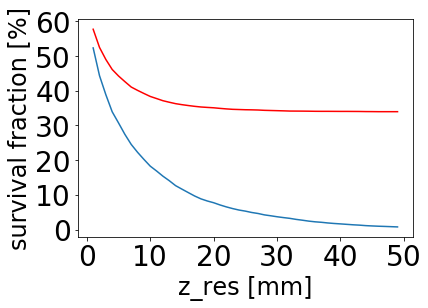

In [84]:
x = np.arange(1,50,1)
plt.plot(x,result_list_pos[0])
plt.plot(x,result_list_pos[1],color="red")
#plt.plot(x,result_list_pos[2],color="lightgreen")
#plt.plot(x,result_list_pos[3],color="darkgreen")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("z_res [mm]", fontsize=24)
plt.ylabel("survival fraction [%]",fontsize=24)
year = "2019"
month ="08"
day = "04"
filename = "positron_1MeV_test" + "_" + year + "_" + month + "_" + day
figurename = filename +".jpg"
plt.savefig(figurename,dpi=300)
np.savetxt(filename + "_z_.txt",result_list_pos[0])
np.savetxt(filename + "_zxy_.txt" ,result_list_pos[1])
plt.show()